In [1]:
# 1.1 - Find microbial classification information

import pandas as pd

# Read nodes.dmp file
def read_nodes_dmp(nodes_dmp_path):
    cols = ['tax_id', 'parent_tax_id', 'rank']
    nodes_df = pd.read_csv(nodes_dmp_path, sep='\t\|\t', engine='python', usecols=[0, 1, 2], names=cols, index_col=False)
    nodes_df['tax_id'] = nodes_df['tax_id'].astype(int)  # Ensure tax_id column is of integer type
    return nodes_df

# Read names.dmp file
def read_names_dmp(names_dmp_path):
    cols = ['tax_id', 'name_txt', 'unique_name', 'name_class']
    names_df = pd.read_csv(names_dmp_path, sep='\t\|\t', engine='python', usecols=[0, 1, 2, 3], names=cols, index_col=False)
    names_df['tax_id'] = names_df['tax_id'].astype(int)  # Ensure tax_id column is of integer type
    return names_df

# Find classification information for a specific tax_id
def find_classification(tax_id, rank, nodes_df):
    try:
        current_tax_id = tax_id
        while True:
            row = nodes_df[nodes_df['tax_id'] == current_tax_id]
            if row.empty:
                return 'N/A'
            if row.iloc[0]['rank'] == rank:
                return current_tax_id
            current_tax_id = row.iloc[0]['parent_tax_id']
    except Exception as e:
        print(f"Error finding classification for tax_id {tax_id}: {e}")
        return 'N/A'

# Read CSV file containing microbial Taxid and Latin names
def read_microbes_csv(microbes_csv_path):
    microbes_df = pd.read_csv(microbes_csv_path)
    microbes_df['Taxid'] = microbes_df['Taxid'].astype(int)  # Ensure Taxid column is of integer type
    return microbes_df

# Main program
if __name__ == '__main__':
    nodes_dmp_path = 'C:/Users/86187/Desktop/nodes.dmp'
    names_dmp_path = 'C:/Users/86187/Desktop/names.dmp'
    microbes_csv_path = 'C:/Users/86187/Desktop/HTPMs.csv'
    nodes_df = read_nodes_dmp(nodes_dmp_path)
    names_df = read_names_dmp(names_dmp_path)
    microbes_df = read_microbes_csv(microbes_csv_path)

    # Find and add classification information
    for rank in ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']:
        microbes_df[rank] = microbes_df['Taxid'].apply(lambda x: find_classification(x, rank, nodes_df))

    # Save results
    microbes_df.to_csv('C:/Users/86187/Desktop/HTPMs.csv', index=False)


In [ ]:
# 1.2 - Detection of suspected input microorganisms
import pandas as pd

# Read the CSV file
file_path = "C:\\Users\\86187\\Desktop\\oth.csv"
data = pd.read_csv(file_path)

# Extract 'Taxid' and 'data' columns
taxid_column = data['Taxid']
data_column = data['data']

# Define the list of dates to check
dates = [
    "2023/2/9", "2023/2/10", "2023/2/15", "2023/2/16", 
    "2023/2/21", "2023/2/22", "2023/2/23", "2023/2/24", 
    "2023/2/27", "2023/2/28", "2023/3/1", "2023/3/2", 
    "2023/3/3", "2023/3/6", "2023/3/7", "2023/3/8", 
    "2023/3/9", "2023/3/10", "2023/3/13", "2023/3/16", 
    "2023/3/20", "2023/3/23", "2023/3/27", "2023/4/17", 
    "2023/4/20"
]

# Create a new DataFrame to store the results
result_df = pd.DataFrame(columns=["Taxid"] + dates)

# Iterate over each unique Taxid
for taxid in taxid_column.unique():
    # Get all data corresponding to the current Taxid
    corresponding_dates = data_column[taxid_column == taxid].tolist()
    
    # Create a new row, initialized to 0
    new_row = [taxid] + [0] * len(dates)
    
    # Mark the corresponding dates
    for i, date in enumerate(dates):
        if date in corresponding_dates:
            new_row[i + 1] = 1  # Mark as 1
            
    # Add the new row to the result DataFrame
    result_df.loc[len(result_df)] = new_row

# Save the results to a new CSV file
result_file_path = "C:\\Users\\86187\\Desktop\\result2.csv"
result_df.to_csv(result_file_path, index=False)

print(f"Results have been saved to {result_file_path}")


In [3]:
# 1.3 - Top 5 dominant microbial abundances for each week and scenario
import pandas as pd
import os

# Specify the directory
directory = r"C:\Users\86187\Desktop\污水\数据\16-分周分场景\分周分场景原始数据"

# Create an empty list to store results
results_list = []

# Create a dictionary containing the required Taxid for each scene
required_taxids = {
    'WTP': [28198, 296, 28220, 40214, 821],
    'WTPrural': [296, 40214, 28198, 1170710, 562],
    'COM': [28198, 296, 86185, 40214, 2676868],
    'HOS': [853, 28198, 821, 562, 1751046],
    'Flight': [853, 821, 820, 28116, 166486]
}

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        
        # Use comma as the delimiter
        data = pd.read_csv(filepath, sep=',') 
        
        # Remove whitespace from column names
        data.columns = data.columns.str.strip()

        # Print the columns found
        print(f"Processing file: {filename}")
        print("Columns found:", data.columns.tolist())
        
        if 'Taxid' not in data.columns or 'Estimate Read' not in data.columns:
            print(f"Error: Required columns not found in {filename}. Skipping this file.")
            continue

        # Process the data
        grouped_data = data.groupby('Taxid')['Estimate Read'].sum().reset_index()
        sum_read = grouped_data['Estimate Read'].sum()
        
        if sum_read > 0:  # Prevent division by zero
            grouped_data['Pi'] = grouped_data['Estimate Read'] / sum_read
        else:
            print(f"Warning: Total Estimate Read is zero in {filename}.")

        file_name = filename[:-4]
        scene = file_name.split('_')[1] if "_" in file_name else None

        if scene in required_taxids:
            required_data = grouped_data[grouped_data['Taxid'].isin(required_taxids[scene])]
            
            for index, row in required_data.iterrows():
                results_list.append({'Filename': file_name, 'Taxid': row['Taxid'], 'Pi': row['Pi']})

# Create a DataFrame from the results list and save it to a CSV file
results = pd.DataFrame(results_list)
results.to_csv(r"C:\Users\86187\Desktop\污水\数据\16-分周分场景\results4.csv", index=False)



Processing file: 10_Flight.csv
Columns found: ['Sample', 'Total_Species_level_Estimated_Reads', 'Type', 'Taxid', 'Scientific Name', 'Chinese Name', 'Human Infection', 'Real Read', 'Estimate Read', 'data', 'type', 'site', 'area', 'week']
Processing file: 10_WTP.csv
Columns found: ['Sample', 'Total_Species_level_Estimated_Reads', 'Type', 'Taxid', 'Scientific Name', 'Chinese Name', 'Human Infection', 'Real Read', 'Estimate Read', 'data', 'type', 'site', 'area', 'week']
Processing file: 10_WTPrural.csv
Columns found: ['Sample', 'Total_Species_level_Estimated_Reads', 'Type', 'Taxid', 'Scientific Name', 'Chinese Name', 'Human Infection', 'Real Read', 'Estimate Read', 'data', 'type', 'site', 'area', 'week']
Processing file: 11_WTP.csv
Columns found: ['Sample', 'Total_Species_level_Estimated_Reads', 'Type', 'Taxid', 'Scientific Name', 'Chinese Name', 'Human Infection', 'Real Read', 'Estimate Read', 'data', 'type', 'site', 'area', 'week']
Processing file: 11_WTPrural.csv
Columns found: ['Sample

In [4]:
# 2 - Calculate diversity indices

import pandas as pd
import numpy as np

# Read the CSV file
data = pd.read_csv('C:/Users/86187/Desktop/pi.csv')

# Group by Taxid and calculate the total of Estimate Read for each group
grouped_data = data.groupby('Taxid')['Estimate Read'].sum().reset_index()

# Extract the Estimate Read column data
read = grouped_data['Estimate Read']

# Calculate the total of column B (Estimate Read)
sum_read = read.sum()
print(f'sum_read: {sum_read}')

# Get the number of rows in the file
S = grouped_data.shape[0] 
print(f'S: {S}')

# Name column C as Pi
grouped_data['Pi'] = grouped_data['Estimate Read'] / sum_read

# Name column D as PiPi
grouped_data['PiPi'] = grouped_data['Pi'] * grouped_data['Pi']

# Calculate the total of column D
sum_pipi = grouped_data['PiPi'].sum()
#print(f'sum_pipi: {sum_pipi}')

# Calculate 1 - sum_pipi
D = 1 - sum_pipi
print(f'D: {D}')

# Name column E as lnPi
grouped_data['lnPi'] = np.log(grouped_data['Pi'])

# Name column F as PilnPi
grouped_data['PilnPi'] = grouped_data['Pi'] * grouped_data['lnPi']

# Calculate the absolute value of the sum of column F
H = abs(grouped_data['PilnPi'].sum())
print(f'H: {H}')

# Calculate H / ln(S)
E = H / np.log(S)
print(f'E: {E}')

max_pi = grouped_data['Pi'].max()
print(f'max_pi: {max_pi}')

# Save the above results to the original file
grouped_data.to_csv('C:/Users/86187/Desktop/污水/数据/12-病原/分月/2R.csv', index=False)

# Create a new DataFrame to save the results
result_df = pd.DataFrame({
    'S': [S],
    'D': [D],
    'H': [H],
    'E': [E],
    'max_pi': [max_pi]
})

# Save the results to a new CSV file
result_df.to_csv('C:/Users/86187/Desktop/result.csv', index=False)


sum_read: 672083
S: 98
D: 0.8296207729332311
H: 2.3756115401600844
E: 0.5181305104586917
max_pi: 0.32613828946722356


D:\py\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# 3.1 - Calculate similarity
import pandas as pd

# Define file paths
file_path1 = "C:/Users/86187/Desktop/2C.csv"
file_path2 = "C:/Users/86187/Desktop/2F.csv"

# Read data and handle exceptions
try:
    df1 = pd.read_csv(file_path1)
    df2 = pd.read_csv(file_path2)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Extract data from the second column
m1i = df1.iloc[:, 1]
m2i = df2.iloc[:, 1]

# Compare the first column data of both files and extract Estimate Read corresponding to the same Taxid
merged_df = pd.merge(df1, df2, on='Taxid', suffixes=('_1', '_2'))

# Check the merged DataFrame
if merged_df.empty:
    print("Merged DataFrame is empty. Please check the Taxid columns in both files.")
    exit()

# Extract Estimate Read data
n1i = merged_df['Estimate Read_1']
n2i = merged_df['Estimate Read_2']

# Convert data to lists
m1i_data = m1i.values.tolist()
m2i_data = m2i.values.tolist()
n1i_data = n1i.values.tolist()
n2i_data = n2i.values.tolist()

# Print lengths for debugging
print(f"Lengths - m1i_data: {len(m1i_data)}, m2i_data: {len(m2i_data)}, n1i_data: {len(n1i_data)}, n2i_data: {len(n2i_data)}")

# Create a new DataFrame to calculate similarity
# Ensure all columns have the same length
min_length = min(len(m1i_data), len(m2i_data), len(n1i_data), len(n2i_data))
df = pd.DataFrame({
    'm1i': m1i_data[:min_length],
    'm2i': m2i_data[:min_length],
    'n1i': n1i_data[:min_length],
    'n2i': n2i_data[:min_length]
})

# Calculate A
df['n1i*n2i'] = df['n1i'] * df['n2i']
sum_n1in2i = df['n1i*n2i'].sum()
A = 2 * sum_n1in2i

# Extract M1 and M2
M1 = df['m1i'].sum()
M2 = df['m2i'].sum()

# Calculate D1 and D2
E1 = (df['m1i'] ** 2).sum()
E2 = (df['m2i'] ** 2).sum()
D1 = E1 / (M1 ** 2) if M1 != 0 else 0
D2 = E2 / (M2 ** 2) if M2 != 0 else 0

# Calculate B
B1 = D1 + D2
B = B1 * M1 * M2 if (M1 * M2) != 0 else 0

# Calculate C
C = A / B if B != 0 else 0

# Output result
print(C)


Lengths - m1i_data: 98, m2i_data: 70, n1i_data: 47, n2i_data: 47
0.2219050658982926


In [ ]:
# 3.2 - Cluster Analysis
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Read data
data = pd.read_csv('C:/Users/86187/Desktop/cluster.csv', encoding='ISO-8859-1', index_col=0)

# Convert to distance matrix
distance_matrix = 1 - data

# Perform clustering using complete linkage method
linked = linkage(distance_matrix, 'complete')

# Draw dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=data.columns, distance_sort='descending')

# Modify x-axis and y-axis
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.yticks([])  # Do not display y-axis labels
plt.tight_layout()  # Automatically adjust subplot parameters to fill the entire figure area

plt.show()


False
False
Int64Index([], dtype='int64')
False


D:\py\anaconda3\Lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.09997403900841656 and the largest is 2.7586641531618747.
  warn(


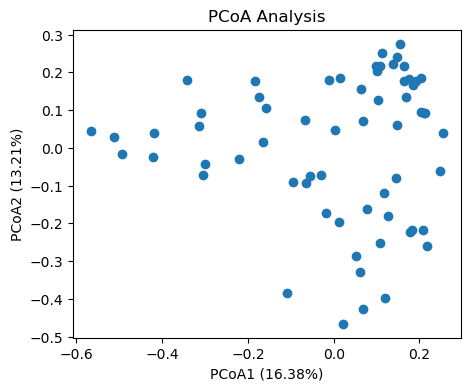

Proportion of variance explained by each component: [0.2079756 0.1240902]
Top 10 variables for PC1:
Variable 1308 contribution to PC1: 25.61%
Variable 1318 contribution to PC1: 24.52%
Variable 1502 contribution to PC1: 24.44%
Variable 1302 contribution to PC1: 22.50%
Variable 1343 contribution to PC1: 22.46%
Variable 45634 contribution to PC1: 21.74%
Variable 1304 contribution to PC1: 21.71%
Variable 1305 contribution to PC1: 20.90%
Variable 150055 contribution to PC1: 19.79%
Variable 59310 contribution to PC1: 19.58%
Top 10 variables for PC2:
Variable 446 contribution to PC2: 23.37%
Variable 197 contribution to PC2: 22.79%
Variable 587 contribution to PC2: 22.63%
Variable 584 contribution to PC2: 22.62%
Variable 585 contribution to PC2: 22.62%
Variable 859 contribution to PC2: 22.62%
Variable 1349 contribution to PC2: 22.62%
Variable 1639 contribution to PC2: 22.62%
Variable 1648 contribution to PC2: 22.62%
Variable 11983 contribution to PC2: 22.62%


In [6]:
# 4. PCoA
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from skbio.stats.ordination import pcoa
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv(r"C:\Users\86187\Desktop\apr.csv")
samples = df.iloc[:, 0]  # Sample names
variables = df.iloc[:, 1:196]  # Variables

print(df.isnull().any().any())  # Check for NaNs
print((variables == 0).all(axis=1).any())  # Check for all-zero rows

# Delete rows where all elements are zero
variables = variables.loc[~(variables==0).all(axis=1)]
# Delete corresponding sample names
samples = samples.loc[variables.index]

# Identify rows where all elements are zero
zero_rows = variables[(variables == 0).all(axis=1)]

# Print the indices of these rows
print(zero_rows.index)

# Data normalization
scaler = MaxAbsScaler()
scaled_variables = scaler.fit_transform(variables)

# Check for infs after scaling
print(np.isinf(scaled_variables).any()) 

# Calculate distance matrix
dist_matrix = pdist(scaled_variables, metric='braycurtis')

# Perform PCoA analysis
pcoa_results = pcoa(dist_matrix)

# Get coordinates of each sample
sample_coords = pcoa_results.samples[['PC1', 'PC2']]

# Plotting
plt.figure(figsize=(5, 4))
plt.scatter(sample_coords['PC1'], sample_coords['PC2'])
#for i, txt in enumerate(samples):
    #plt.annotate(txt, (sample_coords['PC1'].iloc[i], sample_coords['PC2'].iloc[i]))
plt.xlabel('PCoA1 (%.2f%%)' % (pcoa_results.proportion_explained['PC1'] * 100))
plt.ylabel('PCoA2 (%.2f%%)' % (pcoa_results.proportion_explained['PC2'] * 100))
plt.title('PCoA Analysis')
plt.show()

from sklearn.decomposition import PCA

# Perform PCA analysis
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_variables)

# Get the proportion of variance explained by each component
print('Proportion of variance explained by each component:', pca.explained_variance_ratio_)

# Calculate and save the contribution values of each variable as a list
contributions_PC1 = [(variables.columns[i], np.abs(pca.components_[0][i]) * 100) for i in range(len(variables.columns))]
contributions_PC2 = [(variables.columns[i], np.abs(pca.components_[1][i]) * 100) for i in range(len(variables.columns))]

# Sort by contribution size
contributions_PC1.sort(key=lambda x: x[1], reverse=True)
contributions_PC2.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 variables with the highest contributions
print('Top 10 variables for PC1:')
for variable, contribution in contributions_PC1[:10]:
    print('Variable %s contribution to PC1: %.2f%%' % (variable, contribution))

print('Top 10 variables for PC2:')
for variable, contribution in contributions_PC2[:10]:
    print('Variable %s contribution to PC2: %.2f%%' % (variable, contribution))
